In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
import time 
import os 
import geopandas as gpd 
import rasterio as rio
from rasterio.plot import reshape_as_raster, reshape_as_image

# PyTorch imports 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from torchvision.transforms import v2 as transforms

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
np.random.default_rng(seed=0)

Generator(PCG64) at 0x1CECA922EA0

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.get_device_name(0) 

'NVIDIA GeForce RTX 3090'

In [5]:
torch.cuda.memory_allocated()

0

In [6]:
torch.cuda.memory_reserved()

0

In [7]:
# load data
gt_features = np.load('tiled_32x32_stride32_offleft1_offtop1_fullres_height_GT_features.npy')
labels = np.load('tiled_32x32_stride32_offleft1_offtop1_fullres_height_GT_labels.npy')

In [8]:
gt_features.shape

(2402, 11, 32, 32)

In [9]:
labels.shape

(2402,)

In [10]:
np.unique(labels, return_counts=True)

(array([ 2,  4,  5,  6,  8,  9, 11, 12, 13, 14, 16, 17], dtype=int32),
 array([154,  55, 232, 391, 169,  73, 493,  96, 103, 431,  33, 172]))

In [11]:
# remap class values
# Generate a mapping dictionary from the unique values to a continuous range
unique_labels = np.unique(labels)
mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}

# Apply the mapping to the original labels array
remapped_labels = np.array([mapping[label] for label in labels])

print("Remapped labels:", np.unique(remapped_labels))
print(remapped_labels.shape)

Remapped labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
(2402,)


In [12]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

for train_indices, test_indices in sss.split(gt_features, remapped_labels):
    X_train = gt_features[train_indices]
    y_train = remapped_labels[train_indices]

    X_test = gt_features[test_indices]
    y_test = remapped_labels[test_indices]

print(f'Trening: {X_train.shape, y_train.shape}')
print(f'Testing: {X_test.shape, y_test.shape}')

Trening: ((1681, 11, 32, 32), (1681,))
Testing: ((721, 11, 32, 32), (721,))


In [13]:
class TiledImageDatasetAugmentation(Dataset):
    def __init__(self, tiles, labels, num_augmented_samples=0, transform=None):
        """
        Args:
            tiles (numpy array or tensor): Original data (N, C, H, W).
            labels (numpy array or tensor): Labels corresponding to the data.
            num_augmented_samples (int): Number of augmented samples per original sample.
            transform (callable, optional): Augmentation transformations to apply.
        """
        self.tiles = torch.tensor(tiles, dtype=torch.float32)  # Use tensor but no .cuda() yet
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.num_augmented_samples = num_augmented_samples
        self.transform = transform

        # Create indices for both original and augmented data
        self.original_indices = np.arange(len(tiles))
        
        # Augmented indices are repeated according to the num_augmented_samples
        if num_augmented_samples > 0:
            self.augmented_indices = np.tile(self.original_indices, num_augmented_samples)
        else:
            self.augmented_indices = np.array([])  # No augmented indices if none are requested

        # Combined indices
        self.total_indices = np.concatenate([self.original_indices, self.augmented_indices])

        if transform:  
            print("Original Indices Shape:", self.original_indices.shape)
            print("Augmented Indices Shape:", self.augmented_indices.shape)
            print("Total Indices Shape:", self.total_indices.shape)

    def __len__(self):
        return len(self.total_indices)

    def __getitem__(self, idx):
        # Get the original index of the sample
        #original_idx = self.total_indices[idx]
        original_idx = int(self.total_indices[idx]) 
        tile = self.tiles[original_idx]
        label = self.labels[original_idx]

        # Apply the transform only for augmented samples (if present)
        if idx >= len(self.original_indices):
            augmented_idx = idx - len(self.original_indices)
            original_idx = self.augmented_indices[augmented_idx]
            tile = self.tiles[original_idx]
            label = self.labels[original_idx]
            if self.transform:
                tile = self.transform(tile)

        # Move data to GPU if needed
        tile = tile.cuda() if torch.cuda.is_available() else tile
        label = label.cuda() if torch.cuda.is_available() else label

        return tile, label

In [14]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
])

In [18]:
# Define the number of augmented samples per original sample
augmented_samples_per_original_sample = 25

# Initialize the augmented train dataset
train_dataset = TiledImageDatasetAugmentation(
    tiles=X_train,
    labels=y_train,
    num_augmented_samples=augmented_samples_per_original_sample,
    transform=train_transform
)

Original Indices Shape: (1681,)
Augmented Indices Shape: (42025,)
Total Indices Shape: (43706,)


In [19]:
# Verify an original sample and its augmented counterpart
original_idx = 50  # Choose an index for the original sample
tile_original, label_original = train_dataset[original_idx]

augmented_idx = len(train_dataset.original_indices) + original_idx  # Calculate the augmented index
tile_augmented, label_augmented = train_dataset[augmented_idx]

# Print both original and augmented labels to verify
print(f"Original idx: {original_idx}, Original label: {label_original}")
print(f"Augmented idx: {augmented_idx}, Augmented label: {label_augmented}")

Original idx: 50, Original label: 0
Augmented idx: 1731, Augmented label: 0


In [20]:
# Initialize the non-augmented test dataset
test_dataset = TiledImageDatasetAugmentation(X_test, y_test)

In [21]:
batch_size = 360
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for batch_idx, (tiles_batch, labels_batch) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Tiles batch shape: {tiles_batch.shape}")  # (batch_size, 10, 7, 7)
    print(f"Labels batch shape: {labels_batch.shape}")  # (batch_size,)

In [ ]:
for batch_idx, (tiles_batch, labels_batch) in enumerate(test_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Tiles batch shape: {tiles_batch.shape}")  # (batch_size, 10, 7, 7)
    print(f"Labels batch shape: {labels_batch.shape}")  # (batch_size,)

In [22]:
# chatGPT
# Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = self.global_avg_pool(x).view(batch, channels)
        y = F.relu(self.fc1(y))
        y = self.sigmoid(self.fc2(y)).view(batch, channels, 1, 1)
        return x * y

# Depthwise Separable Convolution Block
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# Spatial Attention Block
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size // 2))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

# Advanced LCZ Classifier CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(11, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.se1 = SEBlock(64)

        # Second Convolutional Block with Depthwise Separable Conv
        self.sep_conv1 = DepthwiseSeparableConv(64, 128)
        self.bn2 = nn.BatchNorm2d(128)
        self.se2 = SEBlock(128)

        # Third Convolutional Block with Depthwise Separable Conv
        self.sep_conv2 = DepthwiseSeparableConv(128, 256)
        self.bn3 = nn.BatchNorm2d(256)
        self.se3 = SEBlock(256)

        # Fourth Convolutional Block with Residual Connection
        self.sep_conv3 = DepthwiseSeparableConv(256, 512)
        self.bn4 = nn.BatchNorm2d(512)
        self.se4 = SEBlock(512)

        # Spatial Attention Mechanism
        self.spatial_att = SpatialAttention()

        # Fully Connected Layers
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 12)

    def forward(self, x):
        # First Block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.se1(x)

        # Second Block
        x = F.relu(self.bn2(self.sep_conv1(x)))
        x = self.se2(x)

        # Third Block
        x = F.relu(self.bn3(self.sep_conv2(x)))
        x = self.se3(x)

        # Fourth Block with Spatial Attention
        x = F.relu(self.bn4(self.sep_conv3(x)))
        x = self.se4(x)
        spatial_weight = self.spatial_att(x)
        x = x * spatial_weight

        # Global Pooling and Fully Connected Layers
        x = self.global_pool(x).view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x

In [23]:
# instance modelu 
model = CNNModel()
model = model.cuda()
next(model.parameters()).is_cuda

True

In [24]:
model

CNNModel(
  (conv1): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (se1): SEBlock(
    (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=64, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=64, bias=True)
    (sigmoid): Sigmoid()
  )
  (sep_conv1): DepthwiseSeparableConv(
    (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
    (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (se2): SEBlock(
    (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc1): Linear(in_features=128, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=128, bias=True)
    (sigmoid): Sigmoid()
  )
  (sep_conv2): DepthwiseSeparableConv(
    (depthwise): Conv2d(128, 128, kern

In [25]:
# pocet parametrov modelu 
params = [p.numel() for p in model.parameters() if p.requires_grad]
print(sum(params))

364779


In [26]:
# Cross-Entropy Loss
criterion = nn.CrossEntropyLoss()

In [27]:
learning_rate = 0.0001 

# optimalizátor torch.optim.SGD() nebo Adam()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

#### Learning

In [28]:
# Start training
start = time.time()

# Number of training epochs
num_epochs = 30

# Track losses and accuracies
train_loss, test_loss = [], []
train_accuracy, test_accuracy = [], []

for epoch in range(1, num_epochs+1):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train(True)  # Set training mode
            model.train()
            dataloader = train_loader
        else:
            model.train(False)  # Set evaluation mode
            model.eval()
            dataloader = test_loader

        step = 0
        correct = 0
        total = 0
        
        # Iterate over data
        for x, y in dataloader:
            step += 1
            x = x.cuda()  
            y = y.cuda()

            # Forward pass
            if phase == 'train':
                # Clear gradients
                optimizer.zero_grad()
                # Forward pass
                outputs = model(x)
                # Calculate loss
                loss = criterion(outputs, y.long())
                # Backward pass
                loss.backward()
                # Optimization step
                optimizer.step()
            else:
                # Testing phase
                with torch.no_grad():
                    # Forward pass
                    outputs = model(x)
                    # Calculate loss
                    loss = criterion(outputs, y.long())

            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            batch_accuracy = correct/total
            
            if phase == 'train':
                train_loss.append(loss.item())
                if step % 20 == 0:
                    print(f'Epoch: {epoch} Step: {step} Training Loss: {loss.item():.4f} Accuracy: {batch_accuracy:.4f}')
            else:
                test_loss.append(loss.item())
                #if step % 10 == 0:
                print(f'Epoch: {epoch} Step: {step} Testing Loss: {loss.item():.4f} Accuracy: {batch_accuracy:.4f}')

        # Train and Test Accuracy for epoch
        if phase == 'train': 
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for features, labels in train_loader:
                    outputs = model(features)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    epoch_train_accuracy = correct / total
    
            train_accuracy.append(epoch_train_accuracy)
            print(f'Epoch: {epoch} Training Accuracy: {epoch_train_accuracy:.4f}')
            
        else:
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for features, labels in test_loader:
                    outputs = model(features)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    epoch_test_accuracy = correct / total
    
            test_accuracy.append(epoch_test_accuracy)
            print(f'Epoch: {epoch} Testing Accuracy: {epoch_test_accuracy:.4f}')

    # model checkpointing
    if (epoch_test_accuracy>=0.88) and ((epoch_train_accuracy-epoch_test_accuracy)<=0.05) and (epoch_train_accuracy>epoch_test_accuracy):
        checkpoint = {
            "epoch_num": epoch,
            "model_state": model.state_dict(),
            "train_accuracy": epoch_train_accuracy,
            "test_accuracy": epoch_test_accuracy,
            "gap": epoch_train_accuracy-epoch_test_accuracy
        }
        torch.save(checkpoint, f'model_epoch{epoch}.pth')
        print(f"New model saved at epoch {epoch}.")
        
print('---')
time_elapsed = time.time() - start
print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Epoch: 1 Step: 20 Training Loss: 2.3868 Accuracy: 0.3669
Epoch: 1 Step: 40 Training Loss: 2.2090 Accuracy: 0.4609
Epoch: 1 Step: 60 Training Loss: 1.9409 Accuracy: 0.4993
Epoch: 1 Step: 80 Training Loss: 1.5982 Accuracy: 0.5193
Epoch: 1 Step: 100 Training Loss: 1.3261 Accuracy: 0.5376
Epoch: 1 Step: 120 Training Loss: 1.0559 Accuracy: 0.5534
Epoch: 1 Training Accuracy: 0.6436
Epoch: 1 Step: 1 Testing Loss: 1.1447 Accuracy: 0.6250
Epoch: 1 Step: 2 Testing Loss: 0.9883 Accuracy: 0.6569
Epoch: 1 Step: 3 Testing Loss: 0.0248 Accuracy: 0.6574
Epoch: 1 Testing Accuracy: 0.6574
Epoch: 2 Step: 20 Training Loss: 0.9691 Accuracy: 0.6703
Epoch: 2 Step: 40 Training Loss: 0.8345 Accuracy: 0.6830
Epoch: 2 Step: 60 Training Loss: 0.8096 Accuracy: 0.6994
Epoch: 2 Step: 80 Training Loss: 0.6402 Accuracy: 0.7113
Epoch: 2 Step: 100 Training Loss: 0.5983 Accuracy: 0.7242
Epoch: 2 Step: 120 Training Loss: 0.5761 Accuracy: 0.7332
Epoch: 2 Training Accuracy: 0.7721
Epoch: 2 Step: 1 Testing Loss: 0.6760 Accur

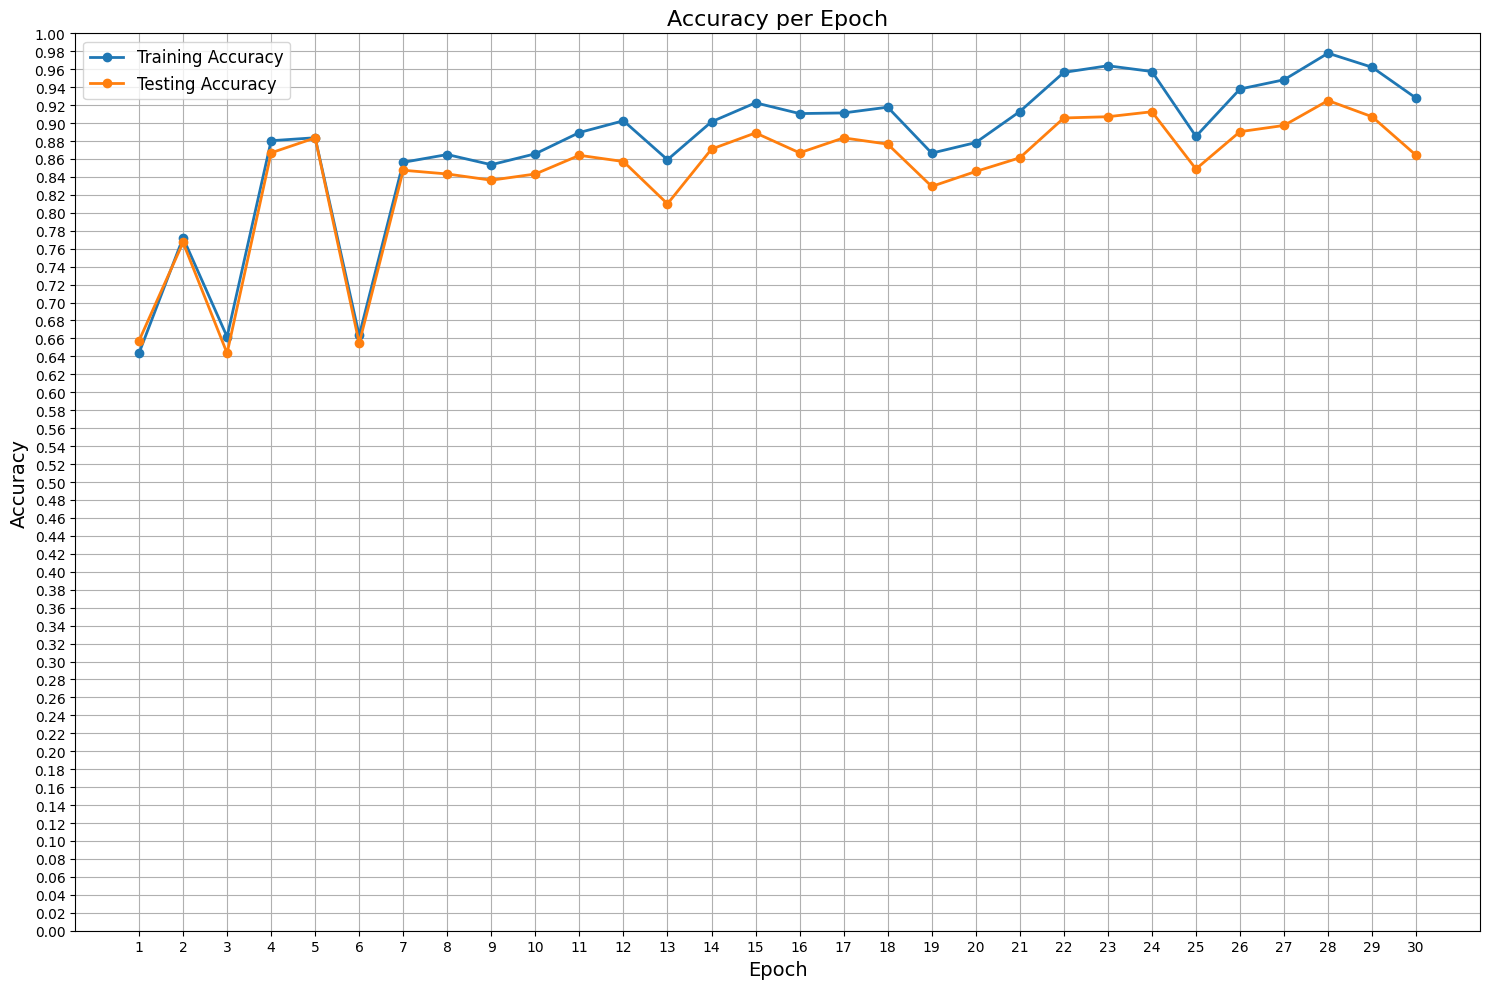

In [29]:
#optimal_epoch = 2
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, '-o', label='Training Accuracy', linewidth=2)
plt.plot(range(1, len(test_accuracy)+1), test_accuracy, '-o', label='Testing Accuracy', linewidth=2)
#plt.axvline(x=optimal_epoch, linestyle='--', label='Optimal epoch')
plt.title('Accuracy per Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(fontsize=12)
plt.yticks(np.arange(0, 1.01, 0.02))
plt.xticks(np.arange(1, num_epochs+1, 1))
plt.tight_layout()

#### Load Checkpointed Models

In [44]:
all_files = os.listdir()
checkpoint_files = [f for f in all_files if 'model_epoch' in f]

# Dictionary to store stats for comparison
saved_stats = []

# Iterate through all saved checkpoint files
for checkpoint_file in checkpoint_files:
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_file)
    
    # Extract stats
    epoch_num = checkpoint["epoch_num"]
    train_accuracy = checkpoint["train_accuracy"]
    test_accuracy = checkpoint["test_accuracy"]
    gap = checkpoint["gap"]
    
    # Print stats
    print(f"Checkpoint: {checkpoint_file}")
    print(f"  Epoch: {epoch_num}")
    print(f"  Train Accuracy: {train_accuracy:.4f}%")
    print(f"  Test Accuracy: {test_accuracy:.4f}%")
    print(f"  Gap (Train - Test): {gap:.4f}%\n")
    
    # Append to stats for comparison
    saved_stats.append({
        "filename": checkpoint_file,
        "epoch": epoch_num,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "gap": gap
    })

Checkpoint: model_epoch15.pth
  Epoch: 15
  Train Accuracy: 0.9226%
  Test Accuracy: 0.8890%
  Gap (Train - Test): 0.0335%

Checkpoint: model_epoch17.pth
  Epoch: 17
  Train Accuracy: 0.9113%
  Test Accuracy: 0.8835%
  Gap (Train - Test): 0.0278%

Checkpoint: model_epoch24.pth
  Epoch: 24
  Train Accuracy: 0.9575%
  Test Accuracy: 0.9126%
  Gap (Train - Test): 0.0448%

Checkpoint: model_epoch26.pth
  Epoch: 26
  Train Accuracy: 0.9379%
  Test Accuracy: 0.8904%
  Gap (Train - Test): 0.0475%

Checkpoint: model_epoch5.pth
  Epoch: 5
  Train Accuracy: 0.8837%
  Test Accuracy: 0.8835%
  Gap (Train - Test): 0.0002%



C:\Users\CZ\AppData\Local\Temp\ipykernel_8652\2638501415.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


In [50]:
model = CNNModel()
model = model.cuda()
next(model.parameters()).is_cuda

True

In [54]:
best_model = 'model_epoch24.pth'

best_model = torch.load(best_model)
model.load_state_dict(best_model['model_state'])

epoch_num = best_model['epoch_num']
train_accuracy = best_model['train_accuracy']
test_accuracy = best_model['test_accuracy']
gap = best_model['gap']

# Optionally, print the stats
print(f"Loaded Model from Epoch {epoch_num}")
print(f"  Train Accuracy: {train_accuracy:.4f}%")
print(f"  Test Accuracy: {test_accuracy:.4f}%")
print(f"  Gap (Train - Test): {gap:.4f}%")

Loaded Model from Epoch 24
  Train Accuracy: 0.9575%
  Test Accuracy: 0.9126%
  Gap (Train - Test): 0.0448%


C:\Users\CZ\AppData\Local\Temp\ipykernel_8652\984683571.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(best_model)


In [55]:
# trenovacia presnost
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for features, labels in train_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Celková přesnost trenovaní: {accuracy:.4f}")

Celková přesnost trenovaní: 0.9577


In [56]:
# Testování modelu 
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Celková přesnost testování: {accuracy:.4f}")

Celková přesnost testování: 0.9126


In [57]:
torch.cuda.memory_allocated()

84951040

In [58]:
del X_train, X_test, y_train, y_test, train_dataset, test_dataset, train_loader, test_loader

In [59]:
torch.cuda.empty_cache()

In [60]:
torch.cuda.memory_allocated()

84951040

#### Prediction

In [61]:
scene = np.load('tiled_32x32_stride10_offleft1_offtop1_fullres_height_features.npy')
scene.shape

(425624, 11, 32, 32)

In [62]:
n_chunks = 400

In [63]:
ints = np.linspace(0, scene.shape[0], n_chunks+1).astype(int)

start = time.time()

all_predictions = []
for i in range(len(ints) - 1):  # Loop over the chunks
    start_idx, end_idx = ints[i], ints[i+1]
    scene_tensor = torch.tensor(scene[start_idx:end_idx, :, :, :], dtype=torch.float32).cuda()

    with torch.no_grad():
        y_pred_chunk = model(scene_tensor)
        y_pred_chunk_cpu = y_pred_chunk.cpu()  # Move the predictions to CPU
        
        # Store predictions from each chunk
        all_predictions.append(y_pred_chunk_cpu)

        print(f'Predicted labels tensor (class probabilities) for chunk {i + 1}: {y_pred_chunk_cpu.shape}')

        del y_pred_chunk, scene_tensor
        torch.cuda.empty_cache()
        torch.cuda.memory_allocated()

# Combine all predictions into a single tensor
y_pred = torch.cat(all_predictions, dim=0)

print(f"All predictions combined shape: {y_pred.shape}")
time_elapsed = time.time() - start
print('Predikce dokončena za {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Predicted labels tensor (class probabilities) for chunk 1: torch.Size([1064, 12])
Predicted labels tensor (class probabilities) for chunk 2: torch.Size([1064, 12])
Predicted labels tensor (class probabilities) for chunk 3: torch.Size([1064, 12])
Predicted labels tensor (class probabilities) for chunk 4: torch.Size([1064, 12])
Predicted labels tensor (class probabilities) for chunk 5: torch.Size([1064, 12])
Predicted labels tensor (class probabilities) for chunk 6: torch.Size([1064, 12])
Predicted labels tensor (class probabilities) for chunk 7: torch.Size([1064, 12])
Predicted labels tensor (class probabilities) for chunk 8: torch.Size([1064, 12])
Predicted labels tensor (class probabilities) for chunk 9: torch.Size([1064, 12])
Predicted labels tensor (class probabilities) for chunk 10: torch.Size([1064, 12])
Predicted labels tensor (class probabilities) for chunk 11: torch.Size([1064, 12])
Predicted labels tensor (class probabilities) for chunk 12: torch.Size([1064, 12])
Predicted lab

In [64]:
# Extract class index with the biggest probability
_, predicted_label = torch.max(y_pred, 1)

print(f'Predicted labels: {predicted_label.shape}')
print(predicted_label)

Predicted labels: torch.Size([425624])
tensor([9, 9, 9,  ..., 7, 7, 3])


#### Export

In [65]:
# Remap class valus back
inverse_mapping = {new_label: old_label for old_label, new_label in mapping.items()}

# Apply the inverse mapping to the remapped labels
predicted_original_labels = np.array([inverse_mapping[label] for label in predicted_label.numpy()])

# Verify
print("Original labels:", np.unique(predicted_original_labels))
print(predicted_original_labels.shape)

Original labels: [ 2  4  5  6  8  9 11 12 13 14 16 17]
(425624,)


In [66]:
# TEST2 - lepsi, funguje taky
import math

# Input parameters
tile_size = (32, 32)  # Width and height of each tile in pixels (T_width, T_height)
stride = 10           # Stride used during tiling in pixels
offset_left = 1       # Offset from the left edge of the image in pixels
offset_top = 1        # Offset from the top edge of the image in pixels
center_size = 10      # Size of the central region (width and height in pixels)
output_tif = f'CNNchat_32x32stride10_tr95.77_te91.26.tif'  # Output GeoTIFF file

# Step 1: Load the original Sentinel image to detect its dimensions
sentinel_image_path = "composite_subset.tif"  # Replace with your file path
with rio.open(sentinel_image_path) as src:
    W_image, H_image = src.width, src.height  # Get image dimensions
    transform = src.transform  # Original georeferencing information
    crs = src.crs  # Coordinate reference system

# Step 2: Calculate the number of tiles per row and column
T_width, T_height = tile_size
tiles_per_row = (W_image - offset_left - T_width) // stride + 1
tiles_per_column = (H_image - offset_top - T_height) // stride + 1

# Ensure predicted_label length matches the number of tiles
total_tiles = tiles_per_row * tiles_per_column
if len(predicted_original_labels) != total_tiles:
    raise ValueError(f"Number of labels ({len(predicted_original_labels)}) does not match expected tiles ({total_tiles}).")

# Step 3: Reconstruct the classification map
classification_map = np.full((H_image, W_image), -1, dtype=int)  # Initialize with -1 for no data

# Calculate half of the central region size for convenience
half_center_size = center_size // 2

for idx, label in enumerate(predicted_original_labels):  # Ensure you use the correct label tensor
    row_idx = idx // tiles_per_row
    col_idx = idx % tiles_per_row

    # Calculate top-left corner of each tile
    top = offset_top + row_idx * stride
    left = offset_left + col_idx * stride

    # Determine the pixel ranges for the central region
    center_row_start = top + (T_height // 2) - half_center_size
    center_row_end = top + (T_height // 2) + half_center_size
    center_col_start = left + (T_width // 2) - half_center_size
    center_col_end = left + (T_width // 2) + half_center_size

    # Assign the label to the central region
    classification_map[
        max(center_row_start, 0):min(center_row_end, H_image),
        max(center_col_start, 0):min(center_col_end, W_image)
    ] = label

# Step 4: Export the classification map as a GeoTIFF
with rio.open(
    output_tif,
    'w',
    driver='GTiff',
    height=classification_map.shape[0],
    width=classification_map.shape[1],
    count=1,  # Single band
    dtype=classification_map.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(classification_map, 1)

print(f"Classification map saved to {output_tif}")

Classification map saved to CNNchat_32x32stride10_tr95.77_te91.26.tif
